## Homogeneous sphere collapse

I hereby present the results of the simulations done with `nbody_sh1` and `treecode` by Barnes and Hut and make a few considerations about the physics of the problem.


## Initial Data
To better understand the choice of our initial datas, we first have to show the conversion we used to go from Internal Units to the cgs system.<br>
From the definition of *centripetal force*<br><br>
$$ 
f_\text{cp} = \dfrac{v^2}{r} = \dfrac{GM}{r^2}
$$
<br>
we define the following *adimensional quantity* for our conversion

$$
\left(\dfrac{GM}{rv^2}\right)_\mathrm{iu} = \left(\dfrac{GM}{rv^2}\right)_\mathrm{cgs} 
$$
<br>

I decided to set a globular cluster with mass $M = 10^5 \ M_\odot$ and typical radius $r = 10$ pc, therefore we can calculate the values of $v$ 

$$
\dfrac{m_\text{cgs}}{m_\text{iu}} = 2 \times 10^{38}\ \mathrm{g} \qquad \dfrac{r_\text{cgs}}{r_\text{iu}} = 3 \times 10^{19} \ \mathrm{cm}
$$

In the cgs units $G = 6.67 \times 10^{-8}$, so the velocity will be

$$
\dfrac{v_\text{cgs}}{v_\text{iu}} = 6 \times 10^{5}\ \mathrm{cm\ s^{-1}} \approx 6\ \mathrm{km\ s^{-1}}
$$

In addition to what was requested by the direct Nbody code, the tree code requires two parameters:
- $\theta_\text{acc}$ is the accuracy parameter, it is defined as the lowest distance two particles can have in our simulation. It is related to the numerical approximation error on the interacting force between particles, the formula is
    $$ 2\theta_\text{acc} = \dfrac{\Delta F_i}{F_i} $$

- $\varepsilon$ is the softening parameter, it's defined as
    
    $$\varepsilon = \bigg(\dfrac{V}{N}\bigg)^{\frac{1}{3}}$$
    
    it defines a dampening term which enters in the equation of the force as
    
    $$ |f_{ij}| = \text{G}\ \dfrac{m_i}{|\vec{r_i} - \vec{r_j}|^2 + \varepsilon^2}\$$
    
    we will use it to eliminate the strong force interactions that could occour in the collapse.<br>
    
- $dt$ is the timestep of integration, a lower value gives a more accurate estimate of the particles positions

### Intepreting the data
The initial data set that we have chosen to simulate a self-collapsing sphere is the following, expressed in internal units:
We have set up the total time of the simulation to be of 50 IU (this will vary) and the ouput to be printed every 0.01 UI, to have enough data to be confronted with the theoretical model. 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML

plt.style.use('../../sim.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.insert(1, '../')
import gdsam

In [3]:
N='1e4'

inp = f'../../data/inputs/hom_sph_{N}.txt'

init = gdsam.initial_data()
init.hom_sph(int(float(N)), 1, 10)
init.initialize_velocities()

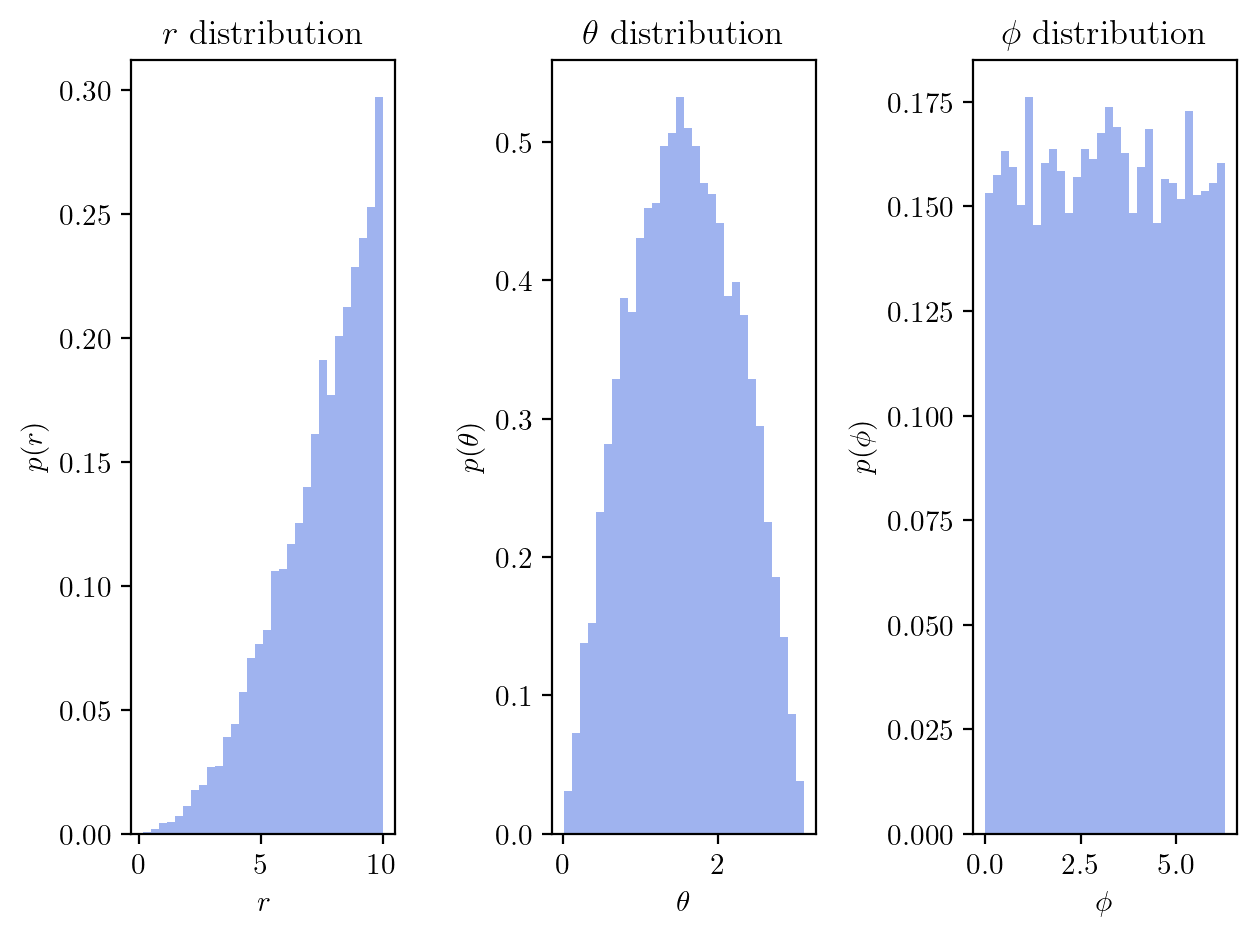

In [4]:
init.show_dist();

Da chiedere al prof

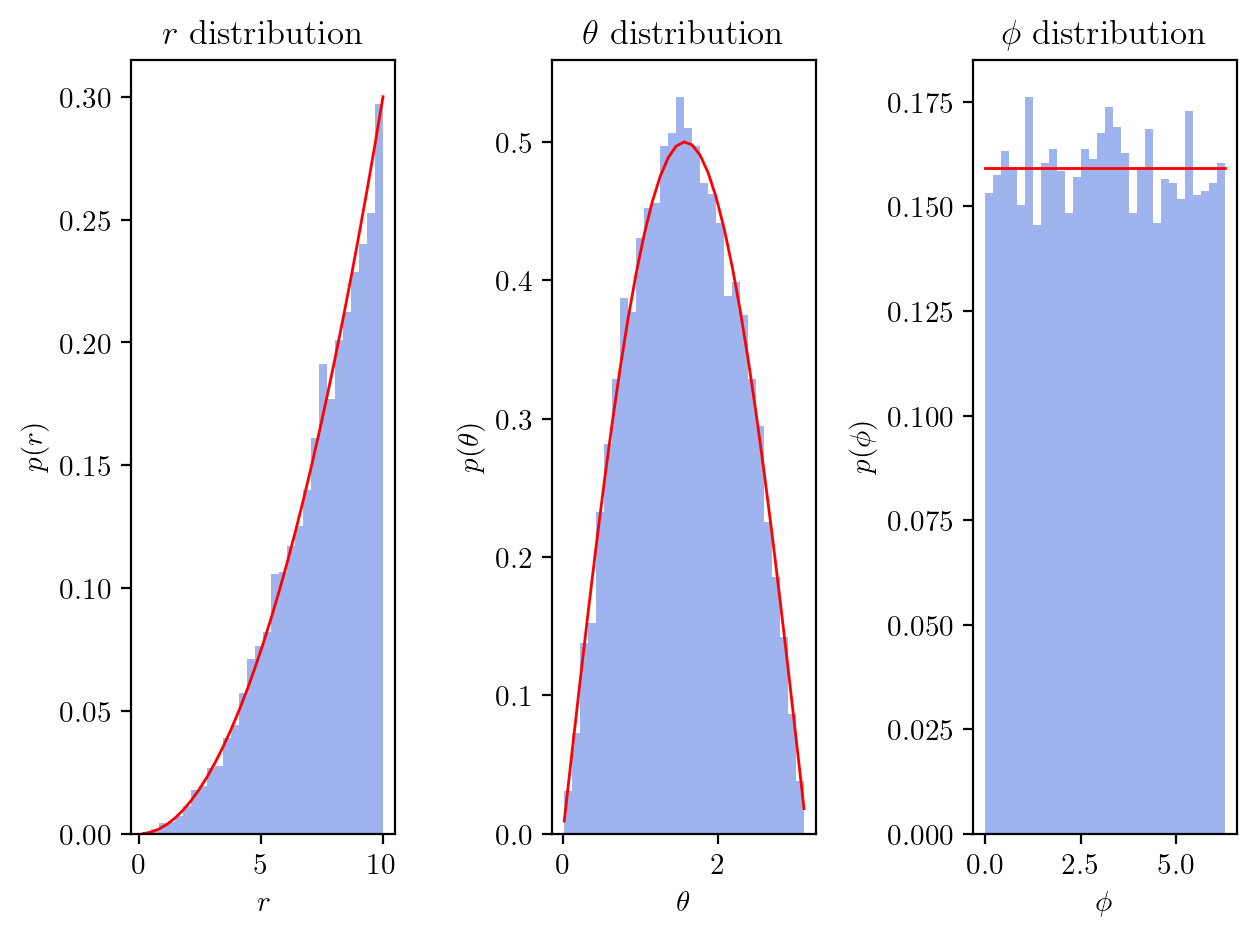

In [5]:
fig, axs = plt.subplots(1, 3, tight_layout=True, sharey=False)
b=30

axs[0].set(title=fr'$r$ distribution', xlabel=r'$r$', ylabel=r'$p(r)$')
c_r, b_r, _ = axs[0].hist(init.r, bins=b, density=True, alpha=.5, color='royalblue', lw=0)
axs[1].set(title=fr'$\theta$ distribution', xlabel=r'$\theta$', ylabel=r'$p(\theta)$')
c_t, b_t, _ =axs[1].hist(init.theta, bins=b, density=True, alpha=.5, color='royalblue', lw=0)
axs[2].set(title=fr'$\phi$ distribution', xlabel=r'$\phi$', ylabel=r'$p(\phi)$')
c_phi, b_phi, _ = axs[2].hist(init.phi, bins=b, density=True, alpha=.5, color='royalblue', lw=0);

prob_r = lambda x: 3*x**2/np.max(init.r)**3
prob_theta = lambda x: 0.5*np.sin(x)
prob_phi = lambda x: np.full(len(x), 1/(2*np.pi))

axs[0].plot(b_r, prob_r(b_r), c='r', lw=1)
axs[1].plot(b_t, prob_theta(b_t), c='r', lw=1)
axs[2].plot(b_phi, prob_phi(b_phi), c='r', lw=1)

#poissonian errors??
bin_centers = (b_r[:-1] + b_r[1:]) / 2
sigma = np.sqrt(c_r/len(c_r))
#axs[0].fill_between(bin_centers, prob_r(bin_centers) - sigma, prob_r(bin_centers)+sigma, color='r', alpha=.1)

In [6]:
init.write_tree(inp)

Now we calculate the softening and accuracy parameters

In [7]:
V = 4/3*np.pi*10**3
epsilon = 1/100 * (V/int(float(N)))**(1/3)
T = np.sqrt(3 * np.pi/ (16*init.rho_mean_sphere(10)) ) #dynamical time

In [8]:
T_sim = round(4 * T)
dt = 1/32
theta = 0.1

In [9]:
print(f'T_sim = {T_sim:.1f} \t epsilon = {epsilon:.2e} \t dt = {dt:.2f}')

T_sim = 199.0 	 epsilon = 7.48e-03 	 dt = 0.03


In [10]:
out = f'../../data/outputs/hom_sph_{N}.txt'
log = f'../../data/outputs/hom_sph_{N}_log.txt'

In [11]:
os.system(f'../../treecode/tree/treecode in={inp} dtime={dt} theta={theta} eps={epsilon} tstop={T_sim} dtout=0.5 out={out} >{log}')

0

In [12]:
pl = gdsam.plotter()
pl.get_data_tree(out)

Loaded 1e+04 particles


In [1]:
pl.projections(10, a=.1, l=15);

NameError: name 'pl' is not defined

  0%|          | 0/399 [00:00<?, ?it/s]

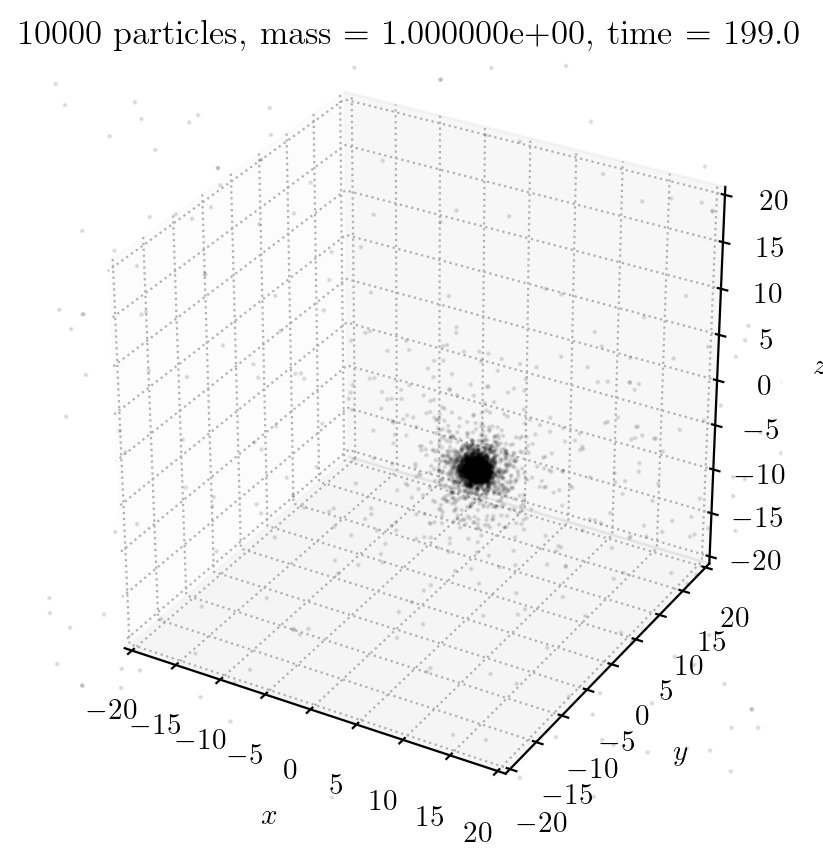

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ani = pl.animate_3d(fig, ax, l=20, s=.5, a=.05)
ani.save(f'../media/hom_sph_{N}.mp4', fps=30, dpi=300)

In [16]:
from IPython.display import Video

Video(f'../media/hom_sph_{N}.mp4', width=600)